# Functions

In [1]:
# Library for utility functions

# Functions and imports

import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm


# ----------
# Functions for Decomposition
# ----------

# Decomposes the desired matrix C based on a criterion
def decompose_C(C, H_mat, mode='condition_number'):
    N_ap = H_mat.shape[2]
    if mode == 'max_singular_value':
        sing_val_max = []
        for m in range(N_ap):
            U, S, V_H = np.linalg.svd(H_mat[:, :, m])
            sing_val_max.append(S[0])
        weights = [s / sum(sing_val_max) for s in sing_val_max]
    elif mode == 'condition_number':
        condition_numbers = []
        for m in range(N_ap):
            U, S, V_H = np.linalg.svd(H_mat[:, :, m])
            condition_number = S[0] / S[-1] if S[-1] > 1e-9 else np.inf  # Avoid divide by zero
            condition_numbers.append(
                1 / condition_number if condition_number != np.inf else 0)  # Reciprocal of condition number
        weights = [cn / sum(condition_numbers) if sum(condition_numbers) != 0 else 1 / N_ap for cn in condition_numbers]
    elif mode == 'frobenius_norm':
        frobenius_norms_inv_power = []
        for m in range(N_ap):
            H_m = H_mat[:, :, m]
            H_m_plus = np.linalg.pinv(H_m)
            fro_norm = np.linalg.norm(H_m_plus, 'fro')
            frobenius_norms_inv_power.append(fro_norm ** (-1) if fro_norm != 0 else 0)  # Reciprocal of Frobenius norm
        weights = [fn / sum(frobenius_norms_inv_power) if sum(frobenius_norms_inv_power) != 0 else 1 / N_ap for fn in
                   frobenius_norms_inv_power]
    else:
        raise ValueError("Invalid mode. Must be one of 'max_singular_value', 'condition_number', or 'frobenius_norm'.")
    return np.array(weights)


# Returns the last 'numVecs' singular vectors of channels for each AP
def return_null_vectors(H_mat, numVecs=1):
    N_ap = H_mat.shape[2]
    v_nulls = []
    for m in range(N_ap):
        U, S, V_H = np.linalg.svd(H_mat[:, :, m])
        V = V_H.conj().T
        columnIdx = int(-1 * numVecs)
        v_nulls.append(V[:, columnIdx:])
    return np.squeeze(np.array(v_nulls))


# ----------
# Functions for Placement and Topology
# ----------

# Generates fixed AP positions on a circle
def generate_AP_positions(N_ap, radius, angle_shift_deg=0):
    ap_origin_distance = radius
    ap_origin_angles_deg = [i * 360 / N_ap + angle_shift_deg for i in range(N_ap)]
    ap_origin_angles_rad = np.deg2rad(ap_origin_angles_deg)
    ap_positions = ap_origin_distance * np.array([np.cos(ap_origin_angles_rad), np.sin(ap_origin_angles_rad)])
    return ap_positions


# Generates random UE positions in a circle
def generate_UE_positions(N_ue, env_radius, random_state=None):
    if random_state is not None:
        np.random.seed(random_state)
    ue_origin_distances = env_radius * np.sqrt(np.random.uniform(0, 1, N_ue))
    ue_origin_angles_deg = np.random.uniform(0, 360, N_ue)
    ue_origin_angles_rad = np.deg2rad(ue_origin_angles_deg)
    ue_positions = ue_origin_distances * np.array([np.cos(ue_origin_angles_rad), np.sin(ue_origin_angles_rad)])
    return ue_positions


# Generates random target positions in a circle
def generate_target_positions(env_radius, N_target=1, random_state=None):
    if random_state is not None:
        np.random.seed(random_state)
    target_distances = env_radius * np.sqrt(np.random.uniform(0, 1, N_target))
    target_angles_deg = np.random.uniform(0, 360)
    target_angles_rad = np.deg2rad(target_angles_deg)
    target_positions = target_distances * np.array([np.cos(target_angles_rad), np.sin(target_angles_rad)])
    return target_positions


# Finds the closest AP to the target position
def find_sensingRxAP(ap_positions, target_position):
    distances = np.linalg.norm(ap_positions - np.tile(target_position.reshape(2, 1), ap_positions.shape[1]), axis=0)
    min_distance_index = np.argmin(distances)
    return min_distance_index


# Plots the network topology (APs, UEs, Target)
def plot_topology(ap_positions, ue_positions, env_radius, target_position=None, fig_margin_ratio=0.1,
                  SHOW_ENV_CIRCLE=True, SHOW_AP_CIRCLE=False, TITLE=True):
    ap_radius = np.linalg.norm(ap_positions[:, 0])
    N_ap = ap_positions.shape[1]
    if target_position is not None:
        sensingRxAP_index = find_sensingRxAP(ap_positions, target_position)
    else:
        sensingRxAP_index = -1
    # Plotting
    circle = plt.Circle((0, 0), env_radius, color='black', fill=False, linestyle='--', linewidth=1.5)
    circle1 = plt.Circle((0, 0), ap_radius, color='black', fill=False, linestyle='--', linewidth=1)
    fig, ax = plt.subplots(figsize=(6, 6))
    if SHOW_ENV_CIRCLE: ax.add_artist(circle)
    if SHOW_AP_CIRCLE: ax.add_artist(circle1)
    LABELED = False
    for i in range(N_ap):
        if i == sensingRxAP_index:
            ax.scatter(ap_positions[0, i], ap_positions[1, i], marker='^', color='green', s=150, label='Sensing Rx AP')
        else:
            if LABELED:
                ax.scatter(ap_positions[0, i], ap_positions[1, i], marker='^', color='red', s=150)
            else:
                ax.scatter(ap_positions[0, i], ap_positions[1, i], marker='^', color='red', s=150, label='Tx APs')
                LABELED = True
    ax.scatter(ue_positions[0, :], ue_positions[1, :], marker='o', color='blue', s=50, label='Users')
    for i, (x, y) in enumerate(zip(ue_positions[0, :], ue_positions[1, :])):
        plt.text(x + 20, y + 20, f'UE{i}', color='blue', fontsize=9)
    if sensingRxAP_index != -1:
        ax.scatter(target_position[0], target_position[1], marker='x', color='black', s=100, label='Target')
    ax.set_xlabel('X Position (m)', fontsize=12)
    ax.set_ylabel('Y Position (m)', fontsize=12)
    if TITLE: ax.set_title('Topology of the Network in a Circular Area')
    ax.legend(loc='upper left', fontsize=10)
    ax.grid(True, alpha=0.4)
    fig_margin = fig_margin_ratio * env_radius
    ax.set_xlim(-env_radius - fig_margin, env_radius + fig_margin)
    ax.set_ylim(-env_radius - fig_margin, env_radius + fig_margin)
    ax.set_aspect('equal', adjustable='box')
    ax.ticklabel_format(axis='both', style='sci', scilimits=(1, 2))
    plt.show()


# ----------
# Functions for Channel Generation
# ----------


# Pathloss (Free Space Path Loss)
def free_space_pathloss(d, fc):
    return (4 * np.pi * d * fc / c) ** 2


# Log-distance path-loss with shadowing
def log_distance_shadowing_pathloss(d, fc, pathloss_exponent=2.5, sigma_dB=4, d0=1):
    c = 3e8  # speed of light
    PL_d0 = 20 * np.log10(4 * np.pi * d0 * fc / c)  # Reference pathloss at d0
    PL_d = PL_d0 + 10 * pathloss_exponent * np.log10(d / d0)
    shadowing = np.random.normal(0, sigma_dB)
    PL_total = PL_d + shadowing
    PL_total_linear = 10 ** (PL_total / 10)
    return PL_total_linear


# UCA array response function
def uca_array_response(M_t, uca_radius, wavelength, azimuth_deg, elevation_deg=90):
    k = 2 * np.pi / wavelength
    azimuth_rad = np.deg2rad(azimuth_deg)
    elevation_rad = np.deg2rad(elevation_deg)
    phi_n = 2 * np.pi * np.arange(M_t) / M_t
    response = np.exp(1j * k * uca_radius * np.sin(elevation_rad) * np.cos(azimuth_rad - phi_n))
    return response


# Spatial correlation matrix using UCA
def spatial_correlation_UCA(M_t, uca_radius, wavelength, angle_deg, angle_spread_deg, elevation_deg=90, samples=100,
                            epsilon=1e-6):
    angles = np.linspace(angle_deg - angle_spread_deg / 2, angle_deg + angle_spread_deg / 2, samples)
    R = np.zeros((M_t, M_t), dtype=complex)
    for ang in angles:
        a = uca_array_response(M_t, uca_radius, wavelength, ang, elevation_deg)
        R += np.outer(a, a.conj())
    R /= samples
    R += epsilon * np.eye(M_t)  # regularize for numerical stability
    return R


# Rician factor based on distance
def distance_based_rician_factor(d, K0_dB=10, d0=1, n=1):
    K_dB = K0_dB - 10 * n * np.log10(d / d0)
    K_linear = 10 ** (K_dB / 10)
    return max(K_linear, 0)


# Printing parameters
def print_parameters(params, length=30, line='='):
    print(line * length)
    print(f'{"Simulation Parameters":^{length}}')
    print('-' * length)
    for key, value in params.items():
        if isinstance(value, float):
            print(f'{key:<{int(length / 2)}}: {value:.2e}')
        elif isinstance(value, np.ndarray):
            array_str = np.array2string(value, formatter={'float_kind': lambda x: f'{x:.2e}'})
            print(f'{key:<{int(length / 2)}}: {array_str}')
        else:
            print(f'{key:<{int(length / 2)}}: {value}')
    print(line * length)


In [2]:
# FUNCTION FOR GENERATING CHANNELS FOR EACH AP
def generate_channels_singleAP(M_t, N_ue, ap_position, ue_positions, h_ap, h_ue, uca_radius=0.5,
                               angle_spread_deg=5, fc=3.5e9, pathloss_exponent=2.5, shadow_sigma_dB=4, K0_dB=10,
                               mode='rician'):
    # Constants
    c = 3e8
    wavelength = c / fc
    # Value/Vector
    angle_spread_deg = np.atleast_1d(angle_spread_deg)
    angle_spread_deg_vector = np.resize(angle_spread_deg, N_ue)
    pathloss_exponent = np.atleast_1d(pathloss_exponent)
    pathloss_exponent_vector = np.resize(pathloss_exponent, N_ue)
    shadow_sigma_dB = np.atleast_1d(shadow_sigma_dB)
    shadow_sigma_dB_vector = np.resize(shadow_sigma_dB, N_ue)
    # Relative Positions
    ue_ap_distances = np.linalg.norm(ue_positions - np.tile(ap_position.reshape(2, 1), ue_positions.shape[1]), axis=0)
    ue_ap_angles_deg = np.rad2deg(np.arctan2(ue_positions[1] - ap_position[1], ue_positions[0] - ap_position[0]))
    ue_ap_angles_deg = (ue_ap_angles_deg + 360) % 360
    ue_elevation_angles_deg = np.rad2deg(np.arctan2(ue_ap_distances, h_ap - h_ue))
    ue_ap_distances_3D = np.sqrt(ue_ap_distances ** 2 + (h_ap - h_ue) ** 2)

    channels = np.zeros((N_ue, M_t), dtype=complex)
    for k in range(N_ue):
        dist_k = ue_ap_distances_3D[k]
        azimuth_k = ue_ap_angles_deg[k]
        elevation_k = ue_elevation_angles_deg[k]
        angle_spread_k = angle_spread_deg_vector[k]
        pl_exponent_k = pathloss_exponent_vector[k]
        sigma_k = shadow_sigma_dB_vector[k]

        R_k = spatial_correlation_UCA(M_t, uca_radius, wavelength, angle_deg=azimuth_k, angle_spread_deg=angle_spread_k,
                                      elevation_deg=elevation_k)
        R_k_sqrt = sqrtm(R_k)

        # Compute large-scale fading
        path_loss_linear = log_distance_shadowing_pathloss(d=dist_k, fc=fc, pathloss_exponent=pl_exponent_k,
                                                           sigma_dB=sigma_k)
        large_scale_fading = 1 / path_loss_linear

        # Rician factor
        if mode == 'rayleigh':
            K_factor = 0
        elif mode == 'rician':
            K_factor = distance_based_rician_factor(dist_k, K0_dB=K0_dB)
        else:
            raise ValueError("Invalid channel mode. Must be one of 'rician' or 'rayleigh'.")

        if K_factor > 0:
            # LoS component
            los_vector = uca_array_response(M_t, uca_radius, wavelength, azimuth_k, elevation_k)
            los_part = np.sqrt(K_factor / (K_factor + 1)) * los_vector
            nlos_part = np.sqrt(1 / (K_factor + 1)) * (np.random.randn(M_t) + 1j * np.random.randn(M_t)) / np.sqrt(2)
            g_k = los_part + nlos_part
        else:
            # Rayleigh fading
            g_k = (np.random.randn(M_t) + 1j * np.random.randn(M_t)) / np.sqrt(2)
        channels[k, :] = np.sqrt(large_scale_fading) * g_k  # R_k_sqrt @ g_k

    return channels

### Rician K-Factor vs. Distance

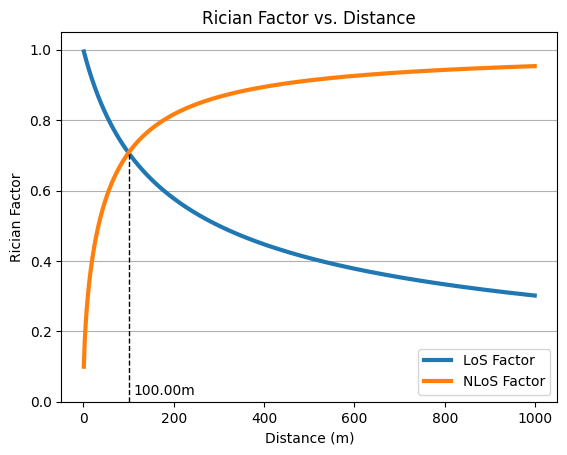

In [3]:
d = np.arange(1, 1000, 1)
K0_dB = 20
K = []
for dist in d:
    K.append(distance_based_rician_factor(dist, K0_dB=K0_dB))
los_factor = []
nlos_factor = []
for k in K:
    los_factor.append(np.sqrt(k / (k + 1)))
    nlos_factor.append(np.sqrt(1 / (k + 1)))
# plt.plot(d, 10*np.log10(K))
plt.plot(d, los_factor, lw=3, label='LoS Factor')
plt.plot(d, nlos_factor, lw=3, label='NLoS Factor')
if K0_dB <= 30:
    plt.vlines(10 ** (K0_dB / 10), 0, np.sqrt(0.5), linestyles='dashed', colors='black', lw=1)
    plt.text(10 ** (K0_dB / 10) + 10, 0.02, f"{10 ** (K0_dB / 10):.2f}m")
plt.ylim([0, 1.05])
plt.grid(axis='y')
plt.legend(loc='best')
plt.xlabel('Distance (m)')
plt.ylabel('Rician Factor')
plt.title('Rician Factor vs. Distance')
plt.show()

## Example Usage

         Simulation Parameters          
----------------------------------------
N_ap                : 4
M_t                 : 16
N_ue                : 8
h_ap                : 10
h_ue                : 1.50e+00
h_target            : 5.00e-01
env_radius          : 1000
ap_radius           : 6.50e+02
fc                  : 3.50e+09
c                   : 3.00e+08
wavelength          : 8.57e-02
uca_radius          : 2.00e-01
target_position     : [4.75e+02 8.16e+01]
sensingRxAP_index   : 0
N_tx_ap             : 3


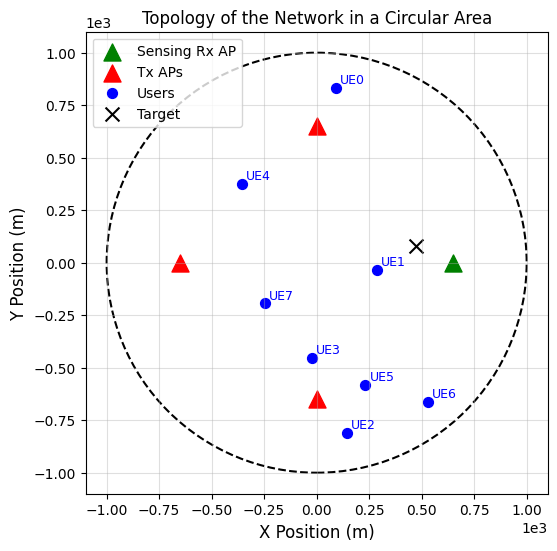

In [4]:
# Parameters
PRINT_PARAMS = 1
N_ap = 4  # Number of APs
M_t = 16  # Number of antennas at BS (UCA)
N_ue = 8  # Number of users
h_ap = 10  # Height of AP in meters
h_ue = 1.5  # Height of user in meters
h_target = 0.5  # Height of target in meters
env_radius = 1000  # Environment radius
ap_radius = env_radius * 0.65
fc = 3.5e9
c = 3e8
wavelength = c / fc
uca_radius = 0.2  # UCA radius (m)

# Positions
ap_positions = generate_AP_positions(N_ap, ap_radius)
ue_positions = generate_UE_positions(N_ue, env_radius, random_state=None)
# ue_positions = np.array([[0], [1000]])
target_position = generate_target_positions(env_radius, N_target=1, random_state=None)
# target_position = np.array([0,0])
sensingRxAP_index = find_sensingRxAP(ap_positions, target_position)
N_tx_ap = N_ap - 1

parameters = {
    "N_ap": N_ap,
    "M_t": M_t,
    "N_ue": N_ue,
    "h_ap": h_ap,
    "h_ue": h_ue,
    "h_target": h_target,
    "env_radius": env_radius,
    "ap_radius": ap_radius,
    "fc": fc,
    "c": c,
    "wavelength": wavelength,
    "uca_radius": uca_radius,
    "target_position": target_position,
    "sensingRxAP_index": sensingRxAP_index,
    "N_tx_ap": N_tx_ap
}
if PRINT_PARAMS: print_parameters(parameters, length=40)

# Plotting the topology
plot_topology(ap_positions, ue_positions, env_radius, target_position=target_position)


In [5]:
# Generating Communication Channels

comm_K0_dB = 10
H_mat = np.zeros((N_ue, M_t, N_ap), dtype=complex)
for m in range(N_ap):
    if m == sensingRxAP_index:
        continue
    angle_spreads_m = np.random.normal(5, 0.1, N_ue)
    angle_spreads_m = np.clip(angle_spreads_m, 0, 10)
    pl_exponents_m = np.random.normal(2.5, 0.1, N_ue)
    pl_exponents_m = np.clip(pl_exponents_m, 2, 3.5)
    shadow_sigmas_m = np.random.normal(5, 1, N_ue)
    shadow_sigmas_m = np.clip(shadow_sigmas_m, 3, 7)
    ap_m = ap_positions[:, m]
    H_m = generate_channels_singleAP(M_t, N_ue, ap_position=ap_m, ue_positions=ue_positions, h_ap=h_ap, h_ue=h_ue,
                                     uca_radius=uca_radius, angle_spread_deg=angle_spreads_m,
                                     fc=fc, pathloss_exponent=pl_exponents_m, shadow_sigma_dB=shadow_sigmas_m,
                                     K0_dB=comm_K0_dB, mode='rician')
    H_m_norm = H_m / np.linalg.norm(H_m, axis=1).reshape(-1, 1)
    H_mat[:, :, m] = H_m_norm

print('Channels Generated with the size:')
print('(N_ue, M_t, N_ap)')
print(H_mat.shape)

Channels Generated with the size:
(N_ue, M_t, N_ap)
(8, 16, 4)


In [11]:
# Generating Sensing Channel

# OFDM Parameters
BW = 20e6  # bandwidth
N_sc = 64  # num of subcarriers
f_sc = BW / N_sc
T_sc = 1 / f_sc
T_cp = (1 / 4) * T_sc
T_sym = T_sc + T_cp
n_subcarrIdx = 10
k_symIdx = 2
reals = 1000
target_shadow_sigma_dB = 2
target_K0_dB = 40

rx_ap_position = ap_positions[:, sensingRxAP_index]
target_position = target_position
rx_target_distance = np.linalg.norm(rx_ap_position - target_position, axis=0)
rx_target_distance_3D = np.sqrt(rx_target_distance ** 2 + (h_ap - h_target) ** 2)
rx_target_angle_deg = np.rad2deg(
    np.arctan2(target_position[1] - rx_ap_position[1], target_position[0] - rx_ap_position[0]))
rx_target_angle_deg = (rx_target_angle_deg + 360) % 360
rx_target_elevation_deg = np.rad2deg(np.arctan2(rx_target_distance, h_ap - h_target))

rx_target_dir = uca_array_response(M_t, uca_radius, wavelength, rx_target_angle_deg, rx_target_elevation_deg)
rx_target_dir = rx_target_dir / np.linalg.norm(rx_target_dir)
a_R = rx_target_dir.reshape(-1, 1)

h_R = generate_channels_singleAP(M_t, 1, ap_position=rx_ap_position, ue_positions=target_position.reshape(2, 1),
                                 h_ap=h_ap, h_ue=h_target, uca_radius=uca_radius, fc=fc,
                                 shadow_sigma_dB=target_shadow_sigma_dB, K0_dB=target_K0_dB, mode='rician')
h_R = h_R.T / np.linalg.norm(h_R)

H_mat_target = np.zeros((M_t, M_t, N_ap), dtype=complex)
for m in range(N_ap):
    if m == sensingRxAP_index:
        continue
    tx_ap_position = ap_positions[:, m]
    target_tx_distance = np.linalg.norm(target_position - tx_ap_position, axis=0)
    target_tx_distance_3D = np.sqrt(target_tx_distance ** 2 + (h_ap - h_target) ** 2)
    target_tx_angle_deg = np.rad2deg(
        np.arctan2(target_position[1] - tx_ap_position[1], target_position[0] - tx_ap_position[0]))
    target_tx_angle_deg = (target_tx_angle_deg + 360) % 360
    target_tx_elevation_deg = np.rad2deg(np.arctan2(target_tx_distance, h_ap - h_target))

    target_tx_dir = uca_array_response(M_t, uca_radius, wavelength, target_tx_angle_deg, target_tx_elevation_deg)
    target_tx_dir = target_tx_dir / np.linalg.norm(target_tx_dir)
    a_T = target_tx_dir.reshape(-1, 1)

    h_T = generate_channels_singleAP(M_t, 1, ap_position=tx_ap_position, ue_positions=target_position.reshape(2, 1),
                                     h_ap=h_ap, h_ue=h_target, uca_radius=uca_radius, fc=fc,
                                     shadow_sigma_dB=target_shadow_sigma_dB, K0_dB=target_K0_dB, mode='rician')
    h_T = h_T.T / np.linalg.norm(h_T)

    beta_rcs = 1
    target_range = rx_target_distance_3D + target_tx_distance_3D
    tau_delay = 0  # target_range / c

    H_m_target = beta_rcs * np.exp(-1 * 2 * np.pi * n_subcarrIdx * f_sc * tau_delay) * (h_R @ h_T.T)
    H_mat_target[:, :, m] = H_m_target

print('H_mat_target Generated with the size:')
print('(M_r, M_t, N_ap)')
print(H_mat_target.shape)

H_mat_target Generated with the size:
(M_r, M_t, N_ap)
(16, 16, 4)


Sensing Beamforming Mode: ns_zf
weights based on condition number: [0.0000, 0.3626, 0.3370, 0.3004]

Alignment for AP 1: 0.7173
Comm Power: 1.0000

Alignment for AP 2: 0.5790
Comm Power: 1.0000

Alignment for AP 3: 0.8948
Comm Power: 1.0000


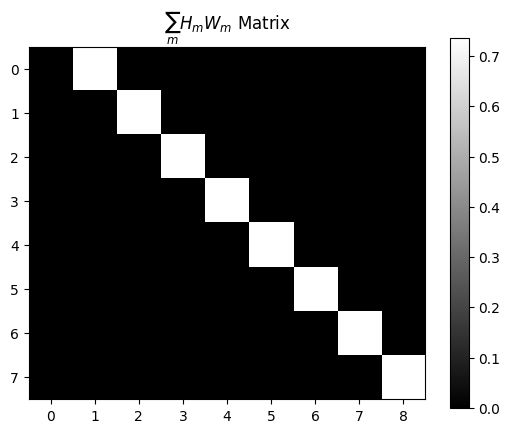

Precoders W_mat Calculated with the size:
(M_t, N_ue+1, N_ap)
(16, 9, 4)


In [8]:
# Calculating Precoders

# Mode 'conj': conjugate
# Mode 'ns_svd': null-space based on SVD
# Mode 'ns_zf': null-space based on ZF beam
sensing_bf_mode = 'ns_zf'
print(f'Sensing Beamforming Mode: {sensing_bf_mode}')

P_sensing_linear = 1
P_comm_linear = 2 - P_sensing_linear

C = np.zeros((N_ue, N_ue + 1), dtype=complex)
C[:, 1:] = np.identity(N_ue, dtype=complex)

if sensing_bf_mode == 'ns_svd':
    numNullVecs = int(M_t / 4)
    v_nulls = return_null_vectors(H_mat, numVecs=numNullVecs)
    if numNullVecs == 1:
        v_nulls = v_nulls.reshape(v_nulls.shape[0], v_nulls.shape[1], 1)

weights = decompose_C(C, H_mat, mode='condition_number')
print('weights based on condition number: [{}]'.format(', '.join('{:.4f}'.format(w) for w in weights)))

H_W = np.zeros((N_ue, N_ue + 1), dtype=complex)
W_mat = np.zeros((M_t, N_ue + 1, N_ap), dtype=complex)
for m in range(N_ap):
    if m == sensingRxAP_index:
        continue
    ap_m = ap_positions[:, m]
    target_distance = np.linalg.norm(target_position - ap_m, axis=0)
    target_angle_deg = np.rad2deg(np.arctan2(target_position[1] - ap_m[1], target_position[0] - ap_m[0]))
    target_angle_deg = (target_angle_deg + 360) % 360
    target_elevation_deg = np.rad2deg(np.arctan2(target_distance, h_ap - h_target))

    target_dir = uca_array_response(M_t, uca_radius, wavelength, target_angle_deg, target_elevation_deg)
    target_dir = target_dir / np.linalg.norm(target_dir)
    d_m = target_dir.reshape(-1, 1)

    H_m = H_mat[:, :, m]
    H_H = H_m.conj().T @ H_m
    H_m_plus = np.linalg.pinv(H_H) @ H_m.conj().T

    W_m = np.zeros((M_t, N_ue + 1), dtype=complex)

    if sensing_bf_mode == 'conj':
        W_m[:, 0] = np.squeeze(d_m)  # conjugate beam directly toward target
    elif sensing_bf_mode == 'ns_svd':
        v_nulls_mat = v_nulls[m, :, :]
        P_null_m = v_nulls_mat @ v_nulls_mat.conj().T
        d_prime_m = P_null_m @ d_m
        d_hat_m = d_prime_m / np.linalg.norm(d_prime_m)
        W_m[:, 0] = np.squeeze(d_hat_m) * np.sqrt(P_sensing_linear)  # projecting on the null space using SVD
    elif sensing_bf_mode == 'ns_zf':
        H_m_null = H_m.conj().T @ np.linalg.pinv(H_m @ H_m.conj().T) @ H_m
        ns_beam = (np.eye(M_t) - H_m_null) @ d_m
        ns_beam = ns_beam / np.linalg.norm(ns_beam)
        W_m[:, 0] = np.squeeze(ns_beam) * np.sqrt(P_sensing_linear)  # null-space beam using comm ZF beam
    else:
        raise ValueError("Invalid sensing beamforming mode. Must be one of 'conj', 'ns_svd', or 'ns_zf'.")

    alignment = np.abs(np.dot(W_m[:, 0].conj().T, target_dir))
    print(f'\nAlignment for AP {m}: {alignment:.4f}')

    W_m_comm = H_m_plus @ (weights[m] * C[:, 1:])
    W_m[:, 1:] = W_m_comm / np.linalg.norm(W_m_comm, 'fro') * np.sqrt(P_comm_linear)
    print(f'Comm Power: {np.sum(np.linalg.norm(W_m[:, 1:], axis=0) ** 2):.4f}')
    H_W += H_m @ W_m
    W_mat[:, :, m] = W_m

plt.imshow(np.abs(H_W), cmap='gray')
plt.colorbar()
plt.title('$\\sum_{m} H_m W_m$ Matrix')
plt.show()
print('Precoders W_mat Calculated with the size:')
print('(M_t, N_ue+1, N_ap)')
print(W_mat.shape)

SINRs for Users: [17.34, 17.34, 17.34, 17.34, 17.34, 17.34, 17.34, 17.34]


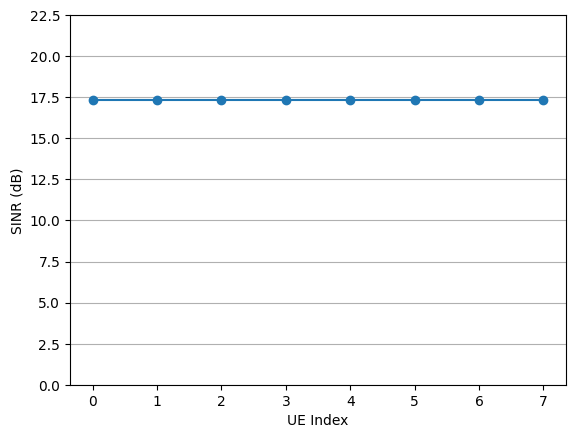

In [10]:
# SINR Based on H_W Matrix

awgn_snr_dB = 20
awgn_snr = 10 ** (awgn_snr_dB / 10)
P_comm = 1
P_sensing = 1
awgn_sigma_sq = P_comm / awgn_snr

sinr_dB = []
for k in range(N_ue):
    P_desired = np.abs(H_W[k, k + 1]) ** 2
    P_interference = np.linalg.norm(H_W[k, :]) ** 2 - P_desired
    sinr = P_desired / (P_interference + awgn_sigma_sq)
    sinr_dB.append(10 * np.log10(sinr))
sinr_dB = np.array(sinr_dB)
print('SINRs for Users: [{}]'.format(', '.join('{:.2f}'.format(s) for s in sinr_dB)))

plt.plot(sinr_dB, marker='o')
y_min = min(np.min(sinr_dB), 0)
y_max = max(np.max(sinr_dB), 22.5)
plt.ylim([y_min, y_max])
plt.grid(axis='y')
plt.xticks(np.arange(N_ue))
plt.xlabel('UE Index')
plt.ylabel('SINR (dB)')
plt.show()


In [12]:
# Channel Correlation Matrix

SHOW_CORRELATION_MATRIX = 0
if SHOW_CORRELATION_MATRIX:
    for m in range(N_ap):
        if m == sensingRxAP_index:
            continue
        H_m = H_mat[:, :, m]
        H_m_norm = H_m / np.linalg.norm(H_m, axis=0)
        R = H_m_norm.conj().T @ H_m_norm / H_m.shape[0]

        plt.imshow(np.abs(R), cmap='gray')
        plt.colorbar()
        plt.xticks(np.arange(M_t))
        plt.yticks(np.arange(M_t))
        plt.xlabel('Antenna Index')
        plt.ylabel('Antenna Index')
        plt.title(f'Channel Correlation Matrix for AP {m}')
        plt.show()

In [13]:
# Sensing SNR

rx_gain_jcs = np.zeros((N_ue + 1), dtype=complex)
for m in range(N_ap):
    if m == sensingRxAP_index:
        continue
    H_m_target = H_mat_target[:, :, m]
    W_m = W_mat[:, :, m]
    W_m_0 = W_mat[:, 0, m]
    rx_gain_jcs += np.squeeze(a_R.conj().T @ H_m_target @ W_m)

sensing_snr = np.linalg.norm(rx_gain_jcs[0]) ** 2 / (np.linalg.norm(a_R) ** 2 * awgn_sigma_sq)
sensing_snr_dB = 10 * np.log10(sensing_snr)
print(f'Sensing-Only SNR: {sensing_snr_dB} dB')

sensing_snr_total = np.linalg.norm(rx_gain_jcs) ** 2 / (np.linalg.norm(a_R) ** 2 * awgn_sigma_sq)
sensing_snr_total_dB = 10 * np.log10(sensing_snr_total)
print(f'Total Sensing SNR: {sensing_snr_total_dB} dB')


Sensing-Only SNR: 13.443134508765429 dB
Total Sensing SNR: 14.935549403125982 dB
